This notebooks simply loads a generator model and spits a series of images

In [24]:
# from __future__ import print_function
%matplotlib inline
# import argparse #generates help messages
import os
import random
import sys
import torch
import torch.nn as nn
from torchvision.utils import save_image
# import torch.nn.parallel # implements data parallelism across multiple devices/GPUs
# import torch.backends.cudnn as cudnn
# import torch.nn.functional as F
# import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)
# import torch.utils.data # for the dataloader class (python iterable over a dataset)
# import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
# import torchvision.transforms as transforms # all transformations for data augmentation (pad, resize, centercrop, ...)
# import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import optuna
# from optuna.trial import TrialState
import logging
# from IPython.display import HTML # to embed html in the Ipython output
# import datetime
# import mlflow
sys.path.append("../src/models/")
sys.path.append("../src/utils/")
from Generator import OptGen
sys.path.append("../src/visualization/")
from utils import normalizeRGB, pixel_to_class, img_to_class, batch_to_class

logging.basicConfig(level=logging.WARNING)
logging.basicConfig(filename='../reports/MVPOptimizer.log') 

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%load_ext autoreload
%autoreload 2

Random Seed:  999
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Load Models

In [3]:
imgFld = '../../cadastralExport/'
dataroot = "../../png/train"

In [4]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(imgFld) if isfile(join(imgFld, f))]
len(onlyfiles)

0

In [5]:
onlyfiles = [f for f in listdir(dataroot) if isfile(join(dataroot, f))]
len(onlyfiles)

103

In [6]:
src = '../models/MVPBestGenerator'

In [50]:
GNet = torch.load(src)
SatelliteGNet = torch.load('../models/WGANSatalliteGenerator') #SyntheticCities/models/WGANSatalliteGenerator
JNB7GNet = torch.load('../models/07NotebookWGANFuncGenerator')
CadastralGNet = torch.load('../models/WGAN_Cadastral_Generator')
CadastralGNetRGB = torch.load('../models/WGAN_CadastralRGB_Generator')

In [8]:
b_size = 64
nz = 100
ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [51]:
# Generate batch of latent vectors
noise = torch.randn(b_size, nz, 1, 1, device=device)
# Generate fake image batch with G
fake = GNet(noise).detach().cpu()
fakeSatellite = SatelliteGNet(noise).detach().cpu()
fakeJNB = JNB7GNet(noise).detach().cpu()
fakeCadastral = CadastralGNet(noise).detach().cpu()
fakeCadastralRGB = CadastralGNetRGB(noise).detach().cpu()

### Model from Cadastral GAN optimisation Notebook

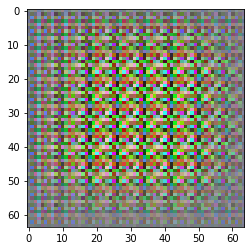

In [66]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(fake[i]).permute(1,2,0));

### Model from WGAN notebook

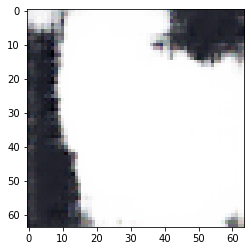

In [73]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(fakeSatellite[i]).permute(1,2,0));

In [80]:
print(SatelliteGNet)

OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): TransConv_2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): DropOut_2): Dropout2d(p=0.30000000000000004, inplace=False)
    (5): BatchNorm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU_2): ReLU(inplace=True)
    (7): TransConv_3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): DropOut_3): Dropout2d(p=0.30000000000000004, inplace=False)
    (9): BatchNorm_3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU_3): ReLU(inplace=True)
    (11): TransConv_4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Dro

### Model after 500 epochs with no optimisation

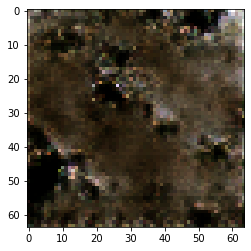

In [94]:
i = random.sample(range(b_size), 1)[0]
plt.imshow(normalizeRGB(fakeJNB[i]).permute(1,2,0));

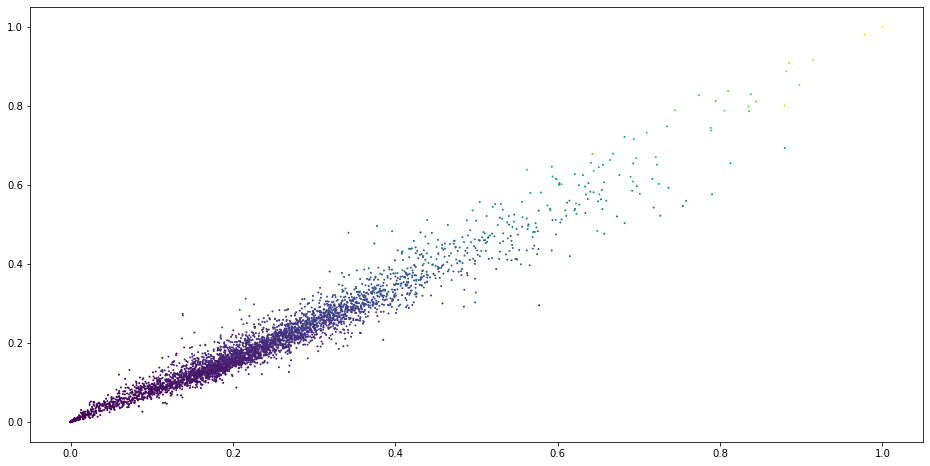

In [95]:
plt.figure(figsize=(16, 8))
plt.scatter(fakeJNB[i][0], fakeJNB[i][1], c = fakeJNB[i][2], s = 1 );

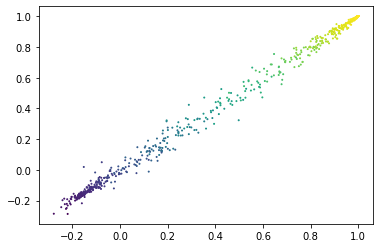

In [96]:
plt.scatter(fakeSatellite[i][0], fakeSatellite[i][1], c = fakeSatellite[i][2], s = 1);

### Cadastral Image Generator

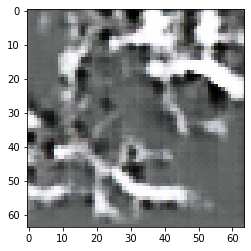

In [298]:
i = random.sample(range(b_size), 1)[0]
plt.figure(figsize=(4,4))
plt.imshow(normalizeRGB(fakeCadastral[i]).permute(1,2,0));

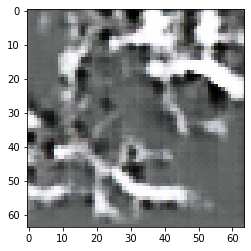

In [301]:
plt.imshow(fakeCadastral[i].permute(1,2,0));

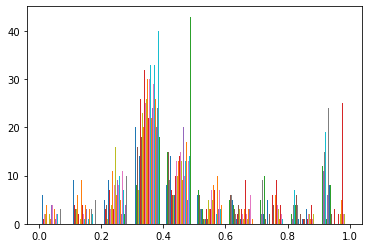

In [304]:
plt.hist(fakeCadastral[i][0]);

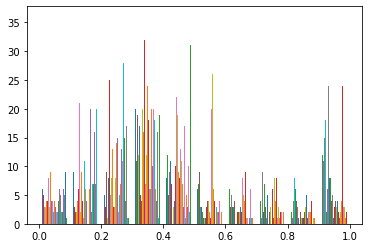

In [305]:
plt.hist(normalizeRGB(fakeCadastral[i][0]));

In [285]:
def regularize(x: float, threshold: float = 0.75):
    '''
    regularize the value of the input x to one of the three standard values 0, 1.5 and 3
    dimgray = 41.18%
    '''
    if x <= threshold:
        x = 0
    elif x >= 3 - threshold:
        x = 1
    else:
        x = 0.4118
    return x

def postprocess_cadastral(img: torch.Tensor, threshold: float = 0.75):
    '''
    postprocesses an image generated by a GNet
    '''
    values = img.sum(axis=0).apply_(lambda m: regularize(m, threshold = threshold)) #(regularize)
    res = torch.cat([values, values, values])
    res = res.view(-1, 64, 64)
    return res

def postprocess_batch(batch: torch.Tensor, threshold: float = 0.75):
    '''
    postprocess a batch of images generated by a GNet
    '''
    res = torch.stack([
    postprocess_cadastral(x_i, threshold = threshold) for i, x_i in enumerate(torch.unbind(batch, dim=0), 0)], dim=0) 
    return res
# batch.apply_(lambda m: postprocess_cadastral(m, threshold = threshold)) 

In [286]:
postprocess_batch(fakeCadastral).size()

torch.Size([64, 3, 64, 64])

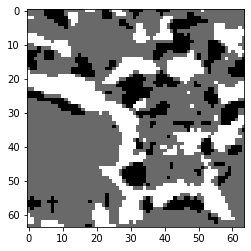

In [287]:
plt.imshow(postprocess_cadastral(fakeCadastral[i], threshold=0.75).permute(1,2,0));

In [278]:
plt.imshow(postprocess_cadastral(fakeCadastral, threshold=0.75)[i].permute(1,2,0));

IndexError: index 40 is out of bounds for dimension 0 with size 9

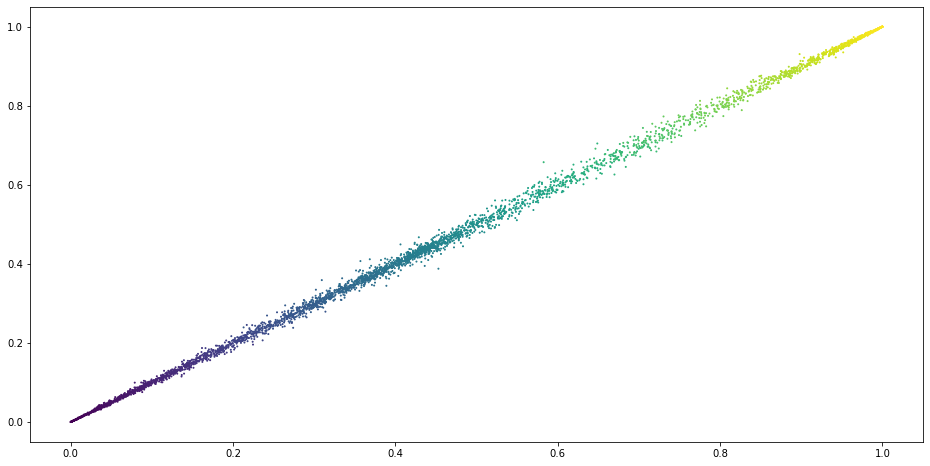

In [29]:
plt.figure(figsize=(16, 8))
plt.scatter(fakeCadastral[i][0], fakeCadastral[i][1], c = fakeCadastral[i][2], s = 1 );

### Cadastral Image Generator with class probabilities

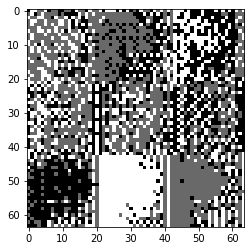

In [52]:
i = random.sample(range(b_size), 1)[0]
plt.figure(figsize=(4,4))
plt.imshow(img_to_class(fakeCadastralRGB[i]).permute(1,2,0));

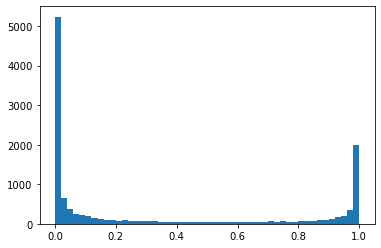

In [53]:
plt.hist(fakeCadastralRGB[i].flatten().tolist(), bins = 50);

In [54]:
fakeCadastralRGB[i].size()

torch.Size([3, 64, 64])

In [55]:
fakeCadastralRGB[i][0][0][0]+fakeCadastralRGB[i][1][0][0]+fakeCadastralRGB[i][2][0][0]

tensor(1.0000)

In [19]:
fakeCadastralRGB[i]

tensor([[[2.5209e-03, 8.8086e-10, 1.4909e-03,  ..., 1.4440e-05,
          2.2473e-13, 3.3293e-06],
         [8.1922e-05, 3.7983e-09, 1.4626e-05,  ..., 1.5618e-06,
          4.6496e-10, 1.2455e-07],
         [2.2350e-03, 4.6055e-07, 4.0109e-03,  ..., 1.1935e-01,
          3.5783e-08, 3.9639e-07],
         ...,
         [1.2525e-03, 4.7873e-06, 9.9755e-03,  ..., 7.8434e-03,
          6.5774e-07, 1.9411e-03],
         [3.1310e-04, 5.3619e-06, 1.6061e-05,  ..., 1.4139e-05,
          3.9072e-07, 3.2198e-07],
         [5.6078e-04, 1.9903e-08, 2.5549e-03,  ..., 4.2854e-06,
          4.8913e-08, 3.5539e-03]],

        [[3.3168e-03, 1.0465e-09, 6.2334e-04,  ..., 2.1953e-06,
          1.4312e-12, 6.7779e-06],
         [2.5324e-05, 1.0303e-09, 1.8808e-05,  ..., 1.0765e-06,
          1.2358e-10, 3.5582e-08],
         [2.7650e-03, 8.7100e-08, 2.4980e-03,  ..., 9.8356e-02,
          1.6839e-08, 1.3787e-07],
         ...,
         [1.6359e-03, 1.2837e-06, 8.0744e-03,  ..., 5.5786e-03,
          2.771